# first GMM APPROACH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse
import math
import edward as ed
import tensorflow as tf
from matplotlib import pyplot as plt

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* halo = []:halos
    * halo[i] :halo for sky i
        * halo[i][0]: sky name
        * halo[i][1]: number of halos
        * halo[i][2]: halo1 x
        * halo[i][3]: halo1 y
        * ...
        * halo[i][7]: halo3 y

In [3]:
path = "~/probp.finalproject/datasets"
all_sky_star = []
for sky in np.arange(1,301,1):
    sky_path = "Train_Skies/Training_Sky"+str(sky)+".csv"
    halo_path = "Training_halos.csv"
    star = (pd.read_csv(path+"/"+sky_path).values)
    all_sky_star.append(star)
halo = (pd.read_csv(path+"/"+halo_path).values)

In [4]:
#plot e1e2
sky = 12
plt.clf()
#plt.scatter(all_sky_star[sky][:,3],all_sky_star[sky][:,4])
print(halo[12,2],halo[12,3])
plt.show()
var_e1 = np.var(all_sky_star[sky][:,3])
var_e2 = np.var(all_sky_star[sky][:,4])
print(var_e1)
print(var_e2)
pos_xy = all_sky_star[sky][:,1:3]
num = pos_xy.shape[0]
e1_e2 = all_sky_star[sky][:,3:5]
print(num)

3551.9 1429.02


0.05220716586945728
0.04845661364146496
677


In [28]:
#plot e1e2
sky = 2
plt.clf()
#plt.scatter(all_sky_star[sky][:,3],all_sky_star[sky][:,4])
#plt.scatter(halo[:,2:4])
#plt.show()

z = MultivariateNormalTriL(
    loc=tf.ones(2),
    scale_tril=tf.cholesky(tf.constant([[1.0, 0.8], [0.8, 1.0]])))
data = halo[:,2:4]
inference = ed.HMC({z: data})
inference.run()
# CRITICISM
sess = ed.get_session()
mean, stddev = sess.run([qz.mean(), qz.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)

fig, ax = plt.subplots()
trace = sess.run(qz.params)
ax.scatter(trace[:, 0], trace[:, 1], marker=".")
mvn_plot_contours(z, ax=ax)
plt.show()

TypeError: Posterior approximation must consist of only Empirical random variables.

In [15]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, Gamma, Empirical

def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

N = num

# Model

X = tf.placeholder(tf.float32, [N, 2])
X_e1 = e1_e2[:,:1].reshape(N).tolist()
X_e2 = e1_e2[:,1:].reshape(N).tolist()

#Xh = Uniform(low=[0.,0.],high=[4200., 4200.])
Xh = Normal(loc=tf.constant([3500., 1500.]), scale=tf.constant(1.0))
m = tf.constant(120.) # Gamma(2.0, 2.0)

sigma = tf.constant(.05) # Normal(loc=tf.zeros(1), scale=tf.ones(1))

l2diff = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))

sess = ed.get_session()

mu = m / tf.maximum(l2diff, 240.)

e1 = Normal(loc = tangential(X, Xh, 0) * mu, scale = sigma)
e2 = Normal(loc = tangential(X, Xh, 1) * mu, scale = sigma)


# Inference

In [14]:
# Inference

# qm = Empirical(params=tf.Variable(tf.zeros(1000)))
qXh = Empirical(params=tf.Variable(tf.zeros([10000, 2])))

inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run()

10000/10000 [100%] ██████████████████████████████ Elapsed: 23s | Acceptance Rate: 1.000


# Criticism

[ 3494.56762695  1495.00695801] [ 155.56506348   66.56338501]


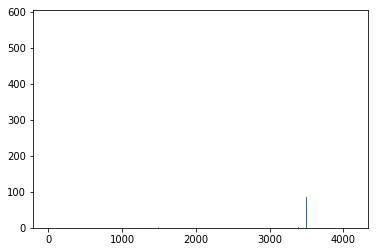

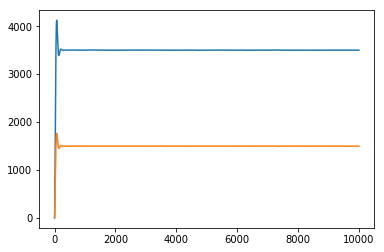

In [16]:
mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
print(mean, stddev)
samples = sess.run(qXh.params)
plt.hist(samples, bins='auto')
plt.show()

# Trace plot.
plt.plot(samples)
plt.show()


# Example

1000/1000 [100%] ██████████████████████████████ Elapsed: 3s | Acceptance Rate: 0.978
Inferred posterior mean:
[ 0.99173146  0.96531749]
Inferred posterior stddev:
[ 0.87583339  0.8712579 ]


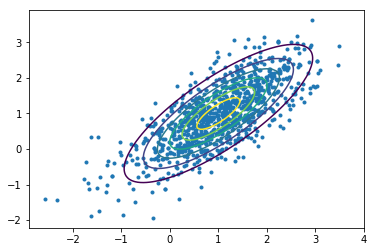

In [7]:
def mvn_plot_contours(z, label=False, ax=None):
  """Plot the contours of 2-d Normal or MultivariateNormal object.
  Scale the axes to show 3 standard deviations.
  """
  sess = ed.get_session()
  mu = sess.run(z.parameters['loc'])
  mu_x, mu_y = mu
  Sigma = sess.run(z.parameters['scale_tril'])
  sigma_x, sigma_y = np.sqrt(Sigma[0, 0]), np.sqrt(Sigma[1, 1])
  xmin, xmax = mu_x - 3 * sigma_x, mu_x + 3 * sigma_x
  ymin, ymax = mu_y - 3 * sigma_y, mu_y + 3 * sigma_y
  xs = np.linspace(xmin, xmax, num=100)
  ys = np.linspace(ymin, ymax, num=100)
  X, Y = np.meshgrid(xs, ys)
  T = tf.cast(np.c_[X.flatten(), Y.flatten()], dtype=tf.float32)
  Z = sess.run(tf.exp(z.log_prob(T))).reshape((len(xs), len(ys)))
  if ax is None:
    fig, ax = plt.subplots()
  cs = ax.contour(X, Y, Z)
  if label:
    plt.clabel(cs, inline=1, fontsize=10)


ed.set_seed(42)

# MODEL
z = MultivariateNormalTriL(
    loc=tf.ones(2),
    scale_tril=tf.cholesky(tf.constant([[1.0, 0.8], [0.8, 1.0]])))

# INFERENCE
qz = Empirical(params=tf.Variable(tf.random_normal([1000, 2])))

inference = ed.HMC({z: qz})
inference.run()

# CRITICISM
sess = ed.get_session()
mean, stddev = sess.run([qz.mean(), qz.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior stddev:")
print(stddev)

fig, ax = plt.subplots()
trace = sess.run(qz.params)
ax.scatter(trace[:, 0], trace[:, 1], marker=".")
mvn_plot_contours(z, ax=ax)
plt.show()